In [ ]:
import tensorflow as tf
import numpy as np
import pathlib
import datetime

# printout versions
print(f"Tensor Flow Version: {tf.__version__}")
print(f"numpy Version: {np.version.version}")

Tensor Flow Version: 2.8.2
numpy Version: 1.21.6


In [ ]:
%load_ext tensorboard

In [ ]:
from keras.utils.np_utils import to_categorical

In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
luna_cancer_data = np.load('/content/drive/MyDrive/Ramasubramanya/LotusFeet/cancernodule_image_900_96_96_patches.npy')
luna_cancer_data = luna_cancer_data[:850]
print(luna_cancer_data.shape, luna_cancer_data[0].shape)

(850, 96, 96, 1) (96, 96, 1)


In [ ]:
luna_cancer_data = luna_cancer_data.reshape(850,96,96)
luna_cancer_data_rgb = np.repeat(luna_cancer_data[..., np.newaxis], 3, -1)
print(luna_cancer_data_rgb.shape, luna_cancer_data_rgb[0].shape)

(850, 96, 96, 3) (96, 96, 3)


In [ ]:
luna_non_cancer_data = np.load("/content/drive/MyDrive/Ramasubramanya/LotusFeet/non_cancernodule_image_1400_96_96_patches.npy")
luna_non_cancer_data = luna_non_cancer_data[:850]
print(luna_non_cancer_data.shape, luna_non_cancer_data[0].shape)

(850, 96, 96, 1) (96, 96, 1)


In [ ]:
luna_non_cancer_data = luna_non_cancer_data.reshape(850,96,96)
luna_non_cancer_data_rgb = np.repeat(luna_non_cancer_data[..., np.newaxis], 3, -1)
print(luna_non_cancer_data_rgb.shape, luna_non_cancer_data_rgb[0].shape)

(850, 96, 96, 3) (96, 96, 3)


In [ ]:
X_luna = np.concatenate((luna_cancer_data_rgb,luna_non_cancer_data_rgb), axis = 0)
print(X_luna.shape, X_luna[0].shape)

(1700, 96, 96, 3) (96, 96, 3)


In [ ]:
cancer_labels = np.ones(850)
noncancer_labels = np.zeros(850)
Y_luna = np.concatenate((cancer_labels,noncancer_labels), axis = 0)

In [ ]:
print(X_luna.shape, Y_luna.shape)

(1700, 96, 96, 3) (1700,)


In [ ]:
from sklearn.model_selection import train_test_split
(X_luna_train, X_luna_test, y_luna_train, y_luna_test) = train_test_split(X_luna, Y_luna,test_size=0.3, stratify=Y_luna, random_state=42)

In [ ]:
print((X_luna_train.shape, X_luna_test.shape, y_luna_train.shape, y_luna_test.shape))

((1190, 96, 96, 3), (510, 96, 96, 3), (1190,), (510,))


In [ ]:
# y_luna_train = to_categorical(y_luna_train, num_classes= 2)
# y_luna_test = to_categorical(y_luna_test, num_classes= 2)
# print(y_luna_train.shape,y_luna_test.shape)

(1190, 2) (510, 2)


In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='categorical_crossentropy',#loss='binary_crossentropy', #
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

xception = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)


 
#building RESNET Model

xception_luna16_model = build_model(xception ,lr = 1e-4)
xception_luna16_model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def train_model_xcpetion_luna16():
  
  # model = create_model()
  xception_luna16_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "xception_model_luna16",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  xception_luna16_model.fit(x=X_luna_train, 
            y=y_luna_train, 
            epochs=20, 
            validation_data=(X_luna_test, y_luna_test), 
            callbacks=[tensorboard_callback])

train_model_xcpetion_luna16()

Epoch 1/20
38/38 [==============================] - 27s 239ms/step - loss: 0.4481 - accuracy: 0.8235 - val_loss: 0.4116 - val_accuracy: 0.7941
Epoch 2/20
38/38 [==============================] - 7s 183ms/step - loss: 0.2999 - accuracy: 0.9151 - val_loss: 2.0146 - val_accuracy: 0.6686
Epoch 3/20
38/38 [==============================] - 7s 182ms/step - loss: 0.1435 - accuracy: 0.9454 - val_loss: 3.5723 - val_accuracy: 0.5412
Epoch 4/20
38/38 [==============================] - 7s 183ms/step - loss: 0.0840 - accuracy: 0.9748 - val_loss: 3.0952 - val_accuracy: 0.5412
Epoch 5/20
38/38 [==============================] - 7s 184ms/step - loss: 0.0499 - accuracy: 0.9840 - val_loss: 1.9587 - val_accuracy: 0.6078
Epoch 6/20
38/38 [==============================] - 7s 184ms/step - loss: 0.0470 - accuracy: 0.9916 - val_loss: 1.4958 - val_accuracy: 0.5667
Epoch 7/20
38/38 [==============================] - 7s 183ms/step - loss: 0.2582 - accuracy: 0.9059 - val_loss: 33.6104 - val_accuracy: 0.4275
Epoc

In [ ]:
def train_model1():
  
  # model = create_model()
  xception_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "xception_model",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  xception_model.fit(x=X_luna_train, 
            y=y_luna_train, 
            epochs=15, 
            validation_data=(X_luna_test, y_luna_test), 
            callbacks=[tensorboard_callback])

train_model1()

Epoch 1/15
38/38 [==============================] - 31s 256ms/step - loss: 0.7599 - accuracy: 0.6924 - val_loss: 281.7643 - val_accuracy: 0.5000
Epoch 2/15
38/38 [==============================] - 6s 159ms/step - loss: 0.3136 - accuracy: 0.8773 - val_loss: 10574.1855 - val_accuracy: 0.5000
Epoch 3/15
38/38 [==============================] - 6s 159ms/step - loss: 0.1809 - accuracy: 0.9336 - val_loss: 119.5041 - val_accuracy: 0.5020
Epoch 4/15
38/38 [==============================] - 6s 158ms/step - loss: 0.0798 - accuracy: 0.9739 - val_loss: 1.0622 - val_accuracy: 0.5549
Epoch 5/15
38/38 [==============================] - 6s 157ms/step - loss: 0.0415 - accuracy: 0.9857 - val_loss: 0.3462 - val_accuracy: 0.8137
Epoch 6/15
38/38 [==============================] - 6s 160ms/step - loss: 0.0254 - accuracy: 0.9950 - val_loss: 0.3112 - val_accuracy: 0.8529
Epoch 7/15
38/38 [==============================] - 6s 162ms/step - loss: 0.0373 - accuracy: 0.9882 - val_loss: 0.2872 - val_accuracy: 0.85

In [ ]:
# extract the predicted probabilities
p_pred_train = xception_luna16_model.predict(X_luna_train)

In [ ]:
y_pred_train = np.where(p_pred_train > 0.5, 1, 0)
print(y_pred_train)

[[1 0]
 [0 1]
 [1 0]
 ...
 [1 0]
 [1 0]
 [0 1]]


In [ ]:
y_luna_train = to_categorical(y_luna_train, num_classes= 2)

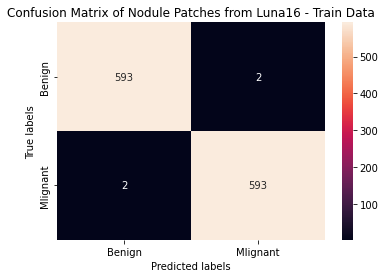

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['Benign','Mlignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_train).argmax(axis=1), np.asarray(y_luna_train).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Nodule Patches from Luna16 - Train Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
# extract the predicted probabilities
p_pred_test = xception_luna16_model.predict(X_luna_test)

In [ ]:
y_pred_test = np.where(p_pred_test > 0.5, 1, 0)
print(y_pred_test)

[[1 0]
 [1 0]
 [0 1]
 ...
 [0 1]
 [0 1]
 [1 0]]


In [ ]:
y_luna_test = to_categorical(y_luna_test, num_classes= 2)

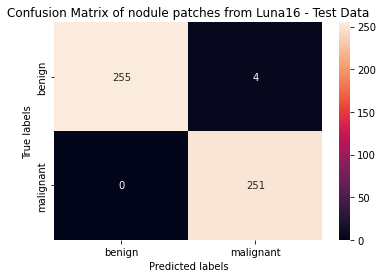

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_test).argmax(axis=1), np.asarray(y_luna_test).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from Luna16 - Test Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
luna_cancer_data = np.load('/content/drive/MyDrive/Ramasubramanya/LotusFeet/cancernodule_image_900_96_96_patches.npy')
testing_luna_cancer_data = luna_cancer_data[850:]
print(testing_luna_cancer_data.shape, testing_luna_cancer_data[0].shape)

(50, 96, 96, 1) (96, 96, 1)


In [ ]:
testing_luna_cancer_data = testing_luna_cancer_data.reshape(50,96,96)
testing_luna_cancer_data_rgb = np.repeat(testing_luna_cancer_data[..., np.newaxis], 3, -1)
print(testing_luna_cancer_data_rgb.shape, testing_luna_cancer_data_rgb[0].shape)

(50, 96, 96, 3) (96, 96, 3)


In [ ]:
luna_non_cancer_data = np.load("/content/drive/MyDrive/Ramasubramanya/LotusFeet/non_cancernodule_image_1400_96_96_patches.npy")
testing_luna_non_cancer_data = luna_non_cancer_data[850:900]
print(testing_luna_non_cancer_data.shape, testing_luna_non_cancer_data[0].shape)

(50, 96, 96, 1) (96, 96, 1)


In [ ]:
testing_luna_non_cancer_data = testing_luna_non_cancer_data.reshape(50,96,96)
testing_luna_non_cancer_data_rgb = np.repeat(testing_luna_non_cancer_data[..., np.newaxis], 3, -1)
print(testing_luna_non_cancer_data_rgb.shape, testing_luna_non_cancer_data_rgb[0].shape)

(50, 96, 96, 3) (96, 96, 3)


In [ ]:
X_lunas = np.concatenate((testing_luna_cancer_data_rgb,testing_luna_non_cancer_data_rgb), axis = 0)
print(X_lunas.shape, X_lunas[0].shape)

(100, 96, 96, 3) (96, 96, 3)


In [ ]:
testing_cancer_labels = np.ones(50)
testing_noncancer_labels = np.zeros(50)
Y_lunas = np.concatenate((testing_cancer_labels,testing_noncancer_labels), axis = 0)

In [ ]:
# extract the predicted probabilities
p_pred_tests = xception_luna16_model.predict(X_lunas)

In [ ]:
y_pred_tests = np.where(p_pred_tests > 0.5, 1, 0)
print(y_pred_tests)

[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


In [ ]:
Y_lunas = to_categorical(Y_lunas, num_classes= 2)

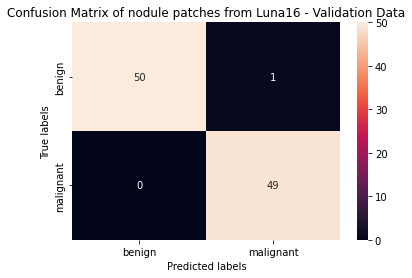

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_tests).argmax(axis=1), np.asarray(Y_lunas).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from Luna16 - Validation Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 4.2 MB/s 


In [ ]:
import visualkeras
visualkeras.layered_view(xception_luna16_model)

In [ ]:
from sklearn.metrics import roc_curve
p_pred_train = xception_luna16_model.predict(X_luna_train)
fpr_train, tpr_train, thresholds_train = roc_curve(np.asarray(y_luna_train).argmax(axis=1), np.asarray(p_pred_train).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_train, tpr_train)

In [ ]:
fpr_train = dict()
tpr_train = dict()
roc_auc = dict()
for i in range(2):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_luna_train[:, i], p_pred_train[:, i])
    roc_auc[i] = auc(fpr_train[i], tpr_train[i])

# Compute micro-average ROC curve and ROC area
# fpr_train["micro"], tpr_train["micro"], _ = roc_curve(y_luna_train.ravel(), p_pred_train.ravel())
# roc_auc["micro"] = auc(fpr_train["micro"], tpr_train["micro"])

In [ ]:
from sklearn.metrics import roc_curve
p_pred_test = xception_luna16_model.predict(X_luna_test)
fpr_test, tpr_test, thresholds_rf = roc_curve(np.asarray(y_luna_test).argmax(axis=1), np.asarray(p_pred_test).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rf = auc(fpr_test, tpr_test)

In [ ]:
fpr_te = dict()
tpr_te = dict()
roc_auc_te = dict()
for i in range(2):
    fpr_te[i], tpr_te[i], _ = roc_curve(y_luna_test[:, i], p_pred_test[:, i])
    roc_auc_te[i] = auc(fpr_te[i], tpr_te[i])

# Compute micro-average ROC curve and ROC area
# fpr_te["micro"], tpr_te["micro"], _ = roc_curve(y_luna_test.ravel(), p_pred_test.ravel())
# roc_auc_te["micro"] = auc(fpr_te["micro"], tpr_te["micro"])

In [ ]:
from sklearn.metrics import roc_curve
p_pred_val = xception_luna16_model.predict(X_lunas)
fpr_rff, tpr_rff, thresholds_rf = roc_curve(np.asarray(Y_lunas).argmax(axis=1), np.asarray(p_pred_val).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rff = auc(fpr_rff, tpr_rff)

In [ ]:
fpr_va = dict()
tpr_va = dict()
roc_auc_va = dict()
for i in range(2):
    fpr_va[i], tpr_va[i], _ = roc_curve(Y_lunas[:, i], p_pred_val[:, i])
    roc_auc[i] = auc(fpr_va[i], fpr_va[i])

# Compute micro-average ROC curve and ROC area
# fpr_va["micro"], tpr_va["micro"], _ = roc_curve(Y_lunas.ravel(), p_pred_val.ravel())
# roc_auc_va["micro"] = auc(fpr_va["micro"], tpr_va["micro"])

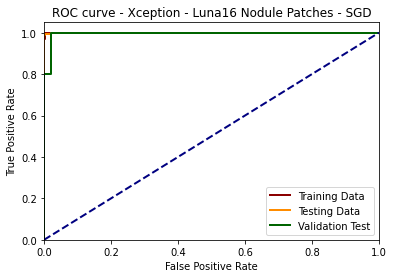

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr_train[1],
    tpr_train[1],
    color="darkred",
    lw=lw,
    label="Training Data" ,
)
plt.plot(
    fpr_te[1],
    tpr_te[1],
    color="darkorange",
    lw=lw,
    label="Testing Data",
)
plt.plot(
    fpr_va[0],
    tpr_va[0],
    color="darkgreen",
    lw=lw,
    label="Validation Test",
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Xception - Luna16 Nodule Patches - SGD")
plt.legend(loc="lower right")
plt.show()

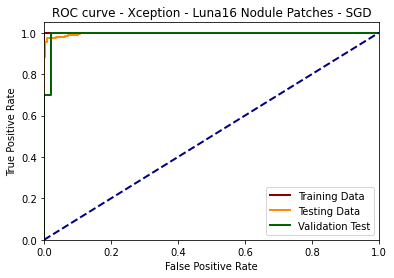

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr_train[1],
    tpr_train[1],
    color="darkred",
    lw=lw,
    label="Training Data" ,
)
plt.plot(
    fpr_te[1],
    tpr_te[1],
    color="darkorange",
    lw=lw,
    label="Testing Data",
)
plt.plot(
    fpr_va[0],
    tpr_va[0],
    color="darkgreen",
    lw=lw,
    label="Validation Test",
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Xception - Luna16 Nodule Patches - SGD")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_luna_train, axis=1), np.argmax(y_pred_train, axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       595
           1       1.00      1.00      1.00       595

    accuracy                           1.00      1190
   macro avg       1.00      1.00      1.00      1190
weighted avg       1.00      1.00      1.00      1190



In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_luna_test, axis=1), np.argmax(p_pred_test, axis=1)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       255
           1       1.00      0.98      0.99       255

    accuracy                           0.99       510
   macro avg       0.99      0.99      0.99       510
weighted avg       0.99      0.99      0.99       510



In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_lunas, axis=1), np.argmax(p_pred_val, axis=1)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.98      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [ ]:
xception_luna16_model.save("/content/drive/MyDrive/Ramasubramanya/CNN_Architectures_Model_Save/xception_luna16_model.h5")

In [ ]:
GAN_Noncancer = np.load('/content/drive/My Drive/yazy/noncancer_lung_04Jun/output/generated_noncancer_nodules_2k_96x96.npy')
GAN_Cancer = np.load('/content/drive/MyDrive/yazy/cancer_lung_29May/output/generated_cancer_nodules_2k_96x96.npy')
print(GAN_Cancer.shape,GAN_Noncancer.shape,GAN_Cancer[0].shape,GAN_Noncancer[0].shape)

(2000, 96, 96, 3) (2000, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
GAN_Cancer = GAN_Cancer[:1700]
GAN_Noncancer = GAN_Noncancer[:1700]
print(GAN_Cancer.shape,GAN_Noncancer.shape,GAN_Cancer[0].shape,GAN_Noncancer[0].shape)

(1700, 96, 96, 3) (1700, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
X_GAN = np.concatenate((GAN_Cancer, GAN_Noncancer), axis = 0)
Y_GAN = np.concatenate((np.ones(1700), np.zeros(1700)), axis = 0)
print(X_GAN.shape, Y_GAN.shape)

(3400, 96, 96, 3) (3400,)


In [ ]:
from sklearn.model_selection import train_test_split
(X_GANtrain, X_GANtest, y_GANtrain, y_GANtest) = train_test_split(X_GAN, Y_GAN,test_size=0.3, stratify=Y_GAN, random_state=42)

In [ ]:
print(X_GANtrain.shape, X_GANtest.shape, y_GANtrain.shape, y_GANtest.shape)

(2380, 96, 96, 3) (1020, 96, 96, 3) (2380,) (1020,)


In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='categorical_crossentropy',#loss='binary_crossentropy', #
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

xception_GAN = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)


 
#building RESNET Model

xception_GAN_model = build_model(xception_GAN ,lr = 1e-4)
xception_GAN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 20,873,770
Trainable params: 20,815,146
No

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def train_model():
  
  # model = create_model()
  xception_GAN_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "inception_model_GAN",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  xception_GAN_model.fit(x=X_GANtrain, 
            y=y_GANtrain, 
            epochs=15, 
            validation_data=(X_GANtest, y_GANtest), 
            callbacks=[tensorboard_callback])

train_model()

Epoch 1/15
75/75 [==============================] - 18s 184ms/step - loss: 0.1753 - accuracy: 0.9357 - val_loss: 0.1402 - val_accuracy: 0.9902
Epoch 2/15
75/75 [==============================] - 12s 155ms/step - loss: 0.0152 - accuracy: 0.9979 - val_loss: 0.0430 - val_accuracy: 1.0000
Epoch 3/15
75/75 [==============================] - 12s 157ms/step - loss: 0.0581 - accuracy: 0.9811 - val_loss: 0.1995 - val_accuracy: 0.9676
Epoch 4/15
75/75 [==============================] - 12s 157ms/step - loss: 0.0350 - accuracy: 0.9908 - val_loss: 0.0103 - val_accuracy: 0.9971
Epoch 5/15
75/75 [==============================] - 12s 156ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 6/15
75/75 [==============================] - 12s 155ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 7/15
75/75 [==============================] - 12s 154ms/step - loss: 3.5637e-04 - accuracy: 1.0000 - val_loss: 4.4127e-04 - val_accuracy

In [ ]:
def train_model():
  
  # model = create_model()
  xception_GAN_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "inception_model_GAN",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  xception_GAN_model.fit(x=X_GANtrain, 
            y=y_GANtrain, 
            epochs=15, 
            validation_data=(X_GANtest, y_GANtest), 
            callbacks=[tensorboard_callback])

train_model()

Epoch 1/15
75/75 [==============================] - 17s 152ms/step - loss: 0.1707 - accuracy: 0.9382 - val_loss: 0.5431 - val_accuracy: 0.8471
Epoch 2/15
75/75 [==============================] - 10s 132ms/step - loss: 0.0558 - accuracy: 0.9773 - val_loss: 0.0321 - val_accuracy: 0.9853
Epoch 3/15
75/75 [==============================] - 10s 133ms/step - loss: 0.0067 - accuracy: 0.9979 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/15
75/75 [==============================] - 10s 132ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 5/15
75/75 [==============================] - 10s 133ms/step - loss: 2.3783e-04 - accuracy: 1.0000 - val_loss: 5.1381e-04 - val_accuracy: 1.0000
Epoch 6/15
75/75 [==============================] - 10s 132ms/step - loss: 2.0372e-04 - accuracy: 1.0000 - val_loss: 2.1381e-04 - val_accuracy: 1.0000
Epoch 7/15
75/75 [==============================] - 10s 133ms/step - loss: 1.2751e-04 - accuracy: 1.0000 - val_loss: 1.3133e-0

In [ ]:
# extract the predicted probabilities
p_pred_GANtrain = xception_GAN_model.predict(X_GANtrain)

In [ ]:
y_pred_GANtrain = np.where(p_pred_GANtrain > 0.5, 1, 0)
print(y_pred_GANtrain)

[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [ ]:
y_GANtrain = to_categorical(y_GANtrain, num_classes= 2)

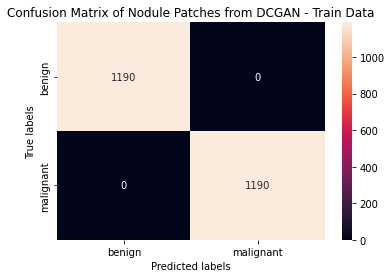

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_GANtrain).argmax(axis=1), np.asarray(y_GANtrain).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Nodule Patches from DCGAN - Train Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
# extract the predicted probabilities
p_pred_GANtest = xception_GAN_model.predict(X_GANtest)

In [ ]:
y_pred_GANtest = np.where(p_pred_GANtest > 0.5, 1, 0)
print(y_pred_GANtest)

[[1 0]
 [1 0]
 [0 1]
 ...
 [1 0]
 [1 0]
 [0 1]]


In [ ]:
y_GANtest = to_categorical(y_GANtest, num_classes= 2)

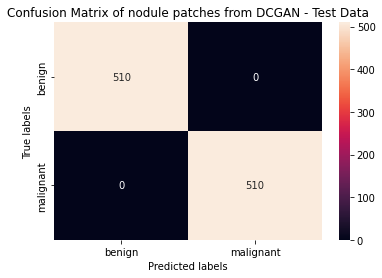

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_GANtest).argmax(axis=1), np.asarray(y_GANtest).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from DCGAN - Test Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
GAN_Noncancer = np.load('/content/drive/My Drive/yazy/noncancer_lung_04Jun/output/generated_noncancer_nodules_2k_96x96.npy')
GAN_Cancer = np.load('/content/drive/MyDrive/yazy/cancer_lung_29May/output/generated_cancer_nodules_2k_96x96.npy')
print(GAN_Cancer.shape,GAN_Noncancer.shape,GAN_Cancer[0].shape,GAN_Noncancer[0].shape)

(2000, 96, 96, 3) (2000, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
testing_GAN_Cancer = GAN_Cancer[1700:]
testing_GAN_Noncancer = GAN_Noncancer[1700:]
print(testing_GAN_Cancer.shape,testing_GAN_Noncancer.shape,testing_GAN_Cancer[0].shape,testing_GAN_Noncancer[0].shape)

(300, 96, 96, 3) (300, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
X_GAN_testing = np.concatenate((testing_GAN_Cancer, testing_GAN_Noncancer), axis = 0)
Y_GAN_testing = np.concatenate((np.ones(300), np.zeros(300)), axis = 0)
print(X_GAN_testing.shape, Y_GAN_testing.shape)

(600, 96, 96, 3) (600,)


In [ ]:
# extract the predicted probabilities
p_predGAN_testing = xception_GAN_model.predict(X_GAN_testing)

In [ ]:
y_pred_GANtesting = np.where(p_predGAN_testing > 0.5, 1, 0)
print(y_pred_GANtesting)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [ ]:
Y_GAN_testing = to_categorical(Y_GAN_testing, num_classes= 2)

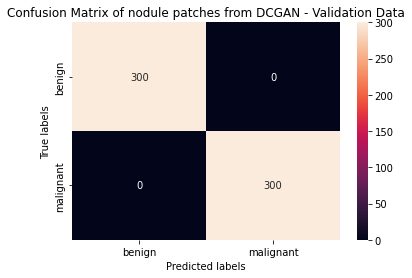

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_GANtesting).argmax(axis=1), np.asarray(Y_GAN_testing).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from DCGAN - Validation Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
from sklearn.metrics import roc_curve
p_GAN_train = xception_GAN_model.predict(X_GANtrain)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.asarray(y_GANtrain).argmax(axis=1), np.asarray(p_GAN_train).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
fpr_GANtrain = dict()
tpr_GANtrain = dict()
roc_GANtrainauc = dict()
for i in range(2):
    fpr_GANtrain[i], tpr_GANtrain[i], _ = roc_curve(y_GANtrain[:, i], p_GAN_train[:, i])
    roc_GANtrainauc[i] = auc(fpr_GANtrain[i], tpr_GANtrain[i])

# Compute micro-average ROC curve and ROC area
# fpr_GANtrain["micro"], tpr_GANtrain["micro"], _ = roc_curve(y_GANtrain.ravel(), p_GAN_train.ravel())
# roc_GANtrainauc["micro"] = auc(fpr_GANtrain["micro"], tpr_GANtrain["micro"])

In [ ]:
from sklearn.metrics import roc_curve
p_GAN_test = xception_GAN_model.predict(X_GANtest)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(np.asarray(y_GANtest).argmax(axis=1), np.asarray(p_GAN_test).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rf = auc(fpr_rf, tpr_rf)

In [ ]:
fpr_GANtest = dict()
tpr_GANtest = dict()
roc_GANtestauc = dict()
for i in range(2):
    fpr_GANtest[i], tpr_GANtest[i], _ = roc_curve(y_GANtest[:, i], p_GAN_test[:, i])
    roc_GANtestauc[i] = auc(fpr_GANtest[i], tpr_GANtest[i])

# Compute micro-average ROC curve and ROC area
# fpr_GANtest["micro"], tpr_GANtest["micro"], _ = roc_curve(y_GANtest.ravel(), p_GAN_test.ravel())
# roc_GANtestauc["micro"] = auc(fpr_GANtest["micro"], tpr_GANtest["micro"])

In [ ]:
from sklearn.metrics import roc_curve
p_GAN_testing = xception_GAN_model.predict(X_GAN_testing)
fpr_rff, tpr_rff, thresholds_rf = roc_curve(np.asarray(Y_GAN_testing).argmax(axis=1), np.asarray(p_GAN_testing).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rff = auc(fpr_rff, tpr_rff)

In [ ]:
fpr_GANtesting = dict()
tpr_GANtesting = dict()
roc_GANtestauc = dict()
for i in range(2):
    fpr_GANtesting[i], tpr_GANtesting[i], _ = roc_curve(Y_GAN_testing[:, i], p_GAN_testing[:, i])
    roc_GANtestauc[i] = auc(fpr_GANtesting[i], tpr_GANtesting[i])

# Compute micro-average ROC curve and ROC area
# fpr_GANtesting["micro"], tpr_GANtesting["micro"], _ = roc_curve(y_GANtest.ravel(), p_GAN_test.ravel())
# roc_GANtestauc["micro"] = auc(fpr_GANtesting["micro"], tpr_GANtesting["micro"])

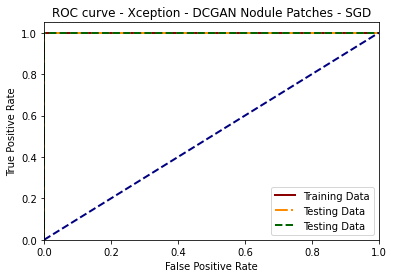

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr_GANtrain[1],
    tpr_GANtrain[1],
    color="darkred",
    lw=lw,
    label="Training Data" ,
)
plt.plot(
    fpr_GANtest[1],
    tpr_GANtest[1],
    color="darkorange",
    lw=lw,
    label="Testing Data",
    linestyle="dashdot",
)
plt.plot(
    fpr_GANtesting[1],
    tpr_GANtesting[1],
    color="darkgreen",
    lw=lw,
    label="Testing Data",
    linestyle="--",
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Xception - DCGAN Nodule Patches - SGD")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_GANtrain, axis=1), np.argmax(p_pred_GANtrain, axis=1)))

from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_GANtest, axis=1), np.argmax(p_GAN_test, axis=1)))

from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_GAN_testing, axis=1), np.argmax(p_GAN_testing, axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1190
           1       1.00      1.00      1.00      1190

    accuracy                           1.00      2380
   macro avg       1.00      1.00      1.00      2380
weighted avg       1.00      1.00      1.00      2380

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       510
           1       1.00      1.00      1.00       510

    accuracy                           1.00      1020
   macro avg       1.00      1.00      1.00      1020
weighted avg       1.00      1.00      1.00      1020

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [ ]:
xception_GAN_model.save("/content/drive/MyDrive/Ramasubramanya/CNN_Architectures_Model_Save/xception_GAN_model.h5")

In [ ]:
!tensorboard dev upload --logdir logs

Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/1TVKPTGgR1q419S6ngfReA/

[2022-07-26T11:27:45] Started scanning logdir.
[2022-07-26T11:28:01] Total uploaded: 210 scalars, 8400 tensors (5.9 MB), 2 binary objects (1.3 MB)
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/program.py", line 276, in main
    return runner(self.flags) or 0
  File "/usr/l